# BC 3 Recommender System

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

April 2022

https://github.com/fpontejos/bc3


## Initial Setup

### Imports


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections

warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import is_color_like

from sklearn.feature_extraction import text


In [2]:
# pip install nltk
import nltk

## Uncomment these on first run
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



In [3]:
# pip install networkx
import networkx as nx

import plotly.offline as py
import plotly.graph_objects as go

# pip install pydot
# pip install graphviz

import pydot
import graphviz

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


### Variables

In [5]:
COLORS = ['#e06666', '#e88b81', '#f0ad9a', '#f8ceb2', '#ffeeca', '#c6cfbf', '#8fb0ae', '#58919d', '#20718b']

CAT_COLORS = ['#20718b', '#7DB082', '#FAEC73', '#ECA052', '#e06666']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#e06666', '#e68d8d', '#ebb1b1', '#efd3d3', '#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_PATH = '../data/'


In [6]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


In [7]:
## Function to plot histograms of numeric features for specified dfframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables", bins=10):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0], bins=bins)
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

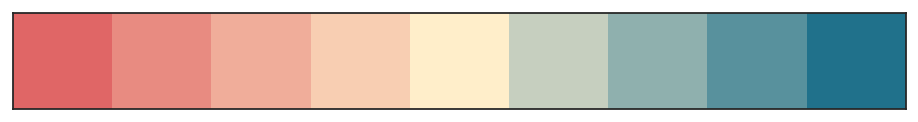

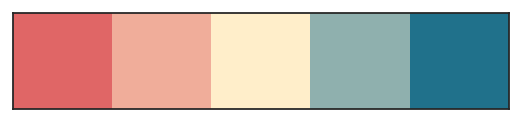

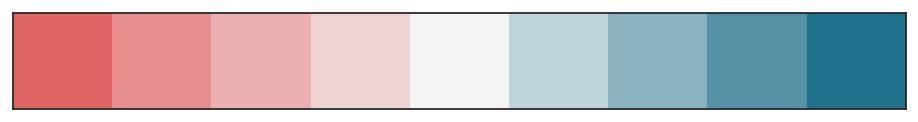

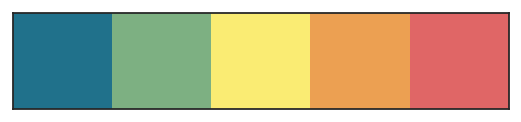

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load df

In [10]:
df = pd.read_csv(DATA_PATH + "data_cleaned.csv")
df_orig = df.copy()

In [11]:
df.head()

,InvoiceNo,Quantity,UnitPrice,Value,CustomerID,InvoiceDate,IsCancelled,Description
0,536365,6,2.55,15.30,17850,2010-12-01 08:26:00,False,hanging heart tlight holder
1,536365,6,3.39,20.34,17850,2010-12-01 08:26:00,False,metal lantern
2,536365,8,2.75,22.00,17850,2010-12-01 08:26:00,False,heart coat hanger
3,536365,6,3.39,20.34,17850,2010-12-01 08:26:00,False,knitted union flag water bottle
4,536365,6,3.39,20.34,17850,2010-12-01 08:26:00,False,woolly heart


In [12]:
df = df.loc[df['IsCancelled']==False]

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
df.dtypes

InvoiceNo              object
Quantity                int64
UnitPrice             float64
Value                 float64
CustomerID              int64
InvoiceDate    datetime64[ns]
IsCancelled              bool
Description            object
dtype: object

In [15]:
df_customer_types = pd.read_csv(DATA_PATH + 'customer_types.csv', index_col='CustomerID')
df_customer_types

,Customer Type
CustomerID,
12346,Wholesale
12347,Wholesale
12348,Wholesale
12349,Wholesale
12350,Retail
...,...
18280,Retail
18281,Retail
18282,Wholesale


In [16]:
df = df.merge(df_customer_types, how='left', right_index=True, left_on='CustomerID')
df.rename(columns={'Customer Type': 'CustomerType'}, inplace=True)
df.head(3)
df.drop(columns=['InvoiceDate', 'Quantity', 'UnitPrice', 'Value', 'IsCancelled'], inplace=True)


## Similar Baskets 

(Customers also bought)

In [17]:
df_ = df.dropna()#.head(500)

In [18]:
#df.loc[df.Description.isna()]

In [19]:
## Remove invoices with only one line item

single_line_inv = df_.groupby(['InvoiceNo']).count().sort_values(by='CustomerID', ascending=True)
single_line_inv = single_line_inv.loc[single_line_inv['CustomerID']==1]
single_line_inv_list = single_line_inv.index.astype(str).tolist()

In [20]:
df_ = df_.loc[~df_['InvoiceNo'].isin(single_line_inv_list)]


In [21]:
df_['CustomerID'] = df_['CustomerID'].astype(int)
df_['InvoiceNo'] = df_['InvoiceNo'].astype(int)
df_inv = df_.set_index('InvoiceNo')

In [22]:
# df_.groupby(['InvoiceNo'])['Description'].apply(','.join).reset_index()

In [23]:
df_inv = df_inv.groupby(['InvoiceNo', 'CustomerID'])['Description'].apply(','.join).reset_index()#.set_index('InvoiceNo')

df_inv['combined'] = df_inv['Description'].str.replace(',', ' ')
df_inv

,InvoiceNo,CustomerID,Description,combined
0,536365,17850,"hanging heart tlight holder,metal lantern,hear...",hanging heart tlight holder metal lantern hear...
1,536366,17850,"hand warmer union jack,hand warmer polka dot",hand warmer union jack hand warmer polka dot
2,536367,13047,"bird ornament,playhouse bedroom,playhouse kitc...",bird ornament playhouse bedroom playhouse kitc...
3,536368,13047,"jam making jar,coat rack paris fashion,coat ra...",jam making jar coat rack paris fashion coat ra...
4,536370,12583,"alarm clock bakelike,alarm clock bakelike,alar...",alarm clock bakelike alarm clock bakelike alar...
...,...,...,...,...
17086,581583,13777,"lunch bag retrospot,love heart tlights",lunch bag retrospot love heart tlights
17087,581584,13777,"flock love heart photo frame,love heart tlights",flock love heart photo frame love heart tlights
17088,581585,15804,"towel design,magnet,glass hanging tlight,glass...",towel design magnet glass hanging tlight glass...
17089,581586,13113,"cake stand hanging strawbery,hanging owl beak,...",cake stand hanging strawbery hanging owl beak ...


## TF-IDF

In [24]:
df_

,InvoiceNo,CustomerID,Description,CustomerType
0,536365,17850,hanging heart tlight holder,Wholesale
1,536365,17850,metal lantern,Wholesale
2,536365,17850,heart coat hanger,Wholesale
3,536365,17850,knitted union flag water bottle,Wholesale
4,536365,17850,woolly heart,Wholesale
...,...,...,...,...
536809,581587,12680,spaceboy napkin,Wholesale
536810,581587,12680,childrens apron dolly,Wholesale
536811,581587,12680,childrens cutlery dolly,Wholesale
536812,581587,12680,childrens cutlery circus parade,Wholesale


In [25]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,3)
                                             for c in combinations(s.split(','), r=i)))
tfidf_matrix = tf.fit_transform(df_inv['Description'])
tfidf_matrix.shape

(17091, 2520916)

In [26]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_inv['InvoiceNo'], columns=df_inv['InvoiceNo'])


In [27]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_inv['InvoiceNo'], columns=df_inv['InvoiceNo'])
print('Shape:', cosine_sim_df.shape)
#cosine_sim_df.sample(5, axis=1).round(4)

Shape: (17091, 17091)


In [28]:
def basket_recommendations(i, sim_df, cols, customer, k=5):
    
    ix = sim_df.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = sim_df.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    
    recs = pd.DataFrame(closest).merge(cols)
    recs = recs.loc[recs.CustomerID != customer]
    
    return recs.head(k)


In [29]:
basket_ = basket_recommendations(581583, cosine_sim_df, df_inv[['InvoiceNo', 'Description', 'CustomerID']], 13777)

In [30]:
basket_

,InvoiceNo,Description,CustomerID
3,539219,"love heart pocket warmer,hand warmer babushka ...",17951


In [31]:
df.loc[df['InvoiceNo']=='581583']

,InvoiceNo,CustomerID,Description,CustomerType
536770,581583,13777,lunch bag retrospot,Wholesale
536771,581583,13777,love heart tlights,Wholesale


In [32]:
df.loc[df['InvoiceNo']=='539219']

,InvoiceNo,CustomerID,Description,CustomerType
32797,539219,17951,love heart pocket warmer,Wholesale
32798,539219,17951,hand warmer babushka design,Wholesale
32799,539219,17951,tlights snowman,Wholesale
32800,539219,17951,love heart tlights,Wholesale


In [33]:
basket_

,InvoiceNo,Description,CustomerID
3,539219,"love heart pocket warmer,hand warmer babushka ...",17951


In [34]:
df.loc[df['InvoiceNo']=='539219']

,InvoiceNo,CustomerID,Description,CustomerType
32797,539219,17951,love heart pocket warmer,Wholesale
32798,539219,17951,hand warmer babushka design,Wholesale
32799,539219,17951,tlights snowman,Wholesale
32800,539219,17951,love heart tlights,Wholesale


In [35]:
df.dtypes

InvoiceNo       object
CustomerID       int64
Description     object
CustomerType    object
dtype: object

In [36]:
df_

,InvoiceNo,CustomerID,Description,CustomerType
0,536365,17850,hanging heart tlight holder,Wholesale
1,536365,17850,metal lantern,Wholesale
2,536365,17850,heart coat hanger,Wholesale
3,536365,17850,knitted union flag water bottle,Wholesale
4,536365,17850,woolly heart,Wholesale
...,...,...,...,...
536809,581587,12680,spaceboy napkin,Wholesale
536810,581587,12680,childrens apron dolly,Wholesale
536811,581587,12680,childrens cutlery dolly,Wholesale
536812,581587,12680,childrens cutlery circus parade,Wholesale


In [37]:
def create_basket(items, customer=99999999):
    """
    create an "invoice"
    """
    return pd.DataFrame(data={'InvoiceNo': [0], 'CustomerID':[customer], 'Description': [(',').join(items)], 'combined': [(' ').join(items)],  })

new_basket = create_basket(['towel design', 'alarm clock bakelike']) 
#pd.concat([df_inv, new_basket])

In [38]:
new_basket = create_basket(['towel design', 'alarm clock bakelike']) 
new_basket


,InvoiceNo,CustomerID,Description,combined
0,0,99999999,"towel design,alarm clock bakelike",towel design alarm clock bakelike


In [39]:
new_basket['InvoiceNo'][0]

0

In [40]:
merged_inv = pd.concat([df_inv, new_basket])
merged_inv

,InvoiceNo,CustomerID,Description,combined
0,536365,17850,"hanging heart tlight holder,metal lantern,hear...",hanging heart tlight holder metal lantern hear...
1,536366,17850,"hand warmer union jack,hand warmer polka dot",hand warmer union jack hand warmer polka dot
2,536367,13047,"bird ornament,playhouse bedroom,playhouse kitc...",bird ornament playhouse bedroom playhouse kitc...
3,536368,13047,"jam making jar,coat rack paris fashion,coat ra...",jam making jar coat rack paris fashion coat ra...
4,536370,12583,"alarm clock bakelike,alarm clock bakelike,alar...",alarm clock bakelike alarm clock bakelike alar...
...,...,...,...,...
17087,581584,13777,"flock love heart photo frame,love heart tlights",flock love heart photo frame love heart tlights
17088,581585,15804,"towel design,magnet,glass hanging tlight,glass...",towel design magnet glass hanging tlight glass...
17089,581586,13113,"cake stand hanging strawbery,hanging owl beak,...",cake stand hanging strawbery hanging owl beak ...
17090,581587,12680,"circus parade lunch box,plaster tin circus par...",circus parade lunch box plaster tin circus par...


In [41]:
def vectorize_invoices(df):
    tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,3)
                                    for c in combinations(s.split(','), r=i)))

    tfidf_matrix = tf.fit_transform(df['Description'])
    
    return tfidf_matrix

## 
## tfidf_matrix = vectorize_invoices(merged_inv)
## 

def make_cosine_matrix(mx, idx ):
    cosine_sim = cosine_similarity(mx)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=idx, columns=idx)
    return cosine_sim_df

## 
## cosine_sim_df = make_cosine_matrix(tfidf_matrix, merged_inv['InvoiceNo'])
## 


In [42]:
basket_#.dtypes

,InvoiceNo,Description,CustomerID
3,539219,"love heart pocket warmer,hand warmer babushka ...",17951


In [43]:

def get_similar_baskets(items, invoices, customerid=-99999999, k=5, idx='InvoiceNo'):
    new_basket = create_basket(items, customerid)
    
    inv_ = pd.concat([invoices, new_basket])
    

    
    ## vectorize invoices
    tfidf_matrix = vectorize_invoices(inv_)
    
    ## make similarity matrix
    similarity_matrix = make_cosine_matrix(tfidf_matrix, inv_[idx])
    
    i = new_basket['InvoiceNo'][0]
    
    ix = similarity_matrix.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))

    closest = similarity_matrix.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    
    recs = pd.DataFrame(closest).merge(inv_[['InvoiceNo', 'Description', 'CustomerID']])
    recs = recs.loc[recs.CustomerID != customerid]
    
    
    return recs



In [44]:
def get_product_recs(similar_baskets, items):
    basket_contents = list(set(','.join(similar_baskets['Description'].tolist()).split(',')))
    diff = list(set(basket_contents) - set(new_items))
    
    return diff

In [45]:
new_items = ['towel design']
new_items_ = ['lunch bag retrospot', 'love heart tlights']

In [46]:
new_items = ['lunch bag retrospot', 'towel design']
similar_baskets = get_similar_baskets(new_items, df_inv, )

In [47]:
similar_baskets

,InvoiceNo,Description,CustomerID
0,538049,"glass dressing table pot,towel design,towel de...",12748
1,552456,"retrospot oven glove,party bunting,child garde...",13999
2,581583,"lunch bag retrospot,love heart tlights",13777
3,565154,"lunch bag design,lunch bag skull,lunch bag ret...",13470
4,562466,"towel design,mirrored disco ball,towel design,...",13435


In [48]:
get_product_recs(similar_baskets, new_items)

['disco ball christmas decoration',
 'zinc willie winkie candle stick',
 'wood garden plant ladder',
 'glass cookie jar',
 'child garden spade',
 'lunch bag design',
 'lunch bag vintage design',
 'party bunting',
 'mirrored disco ball',
 'glass dressing table pot',
 'vintage paisley',
 'spring paper cup',
 'hanging heart jar tlight holder',
 'retrospot cup',
 'lunch bag skull',
 'watering elephant',
 'flag',
 'polkadot bowl',
 'multi colour holder',
 'colour glass tlight holder hanging',
 'colour silk fan',
 'retrospot oven glove',
 'paper bunting coloured lace',
 'paper cup',
 'love heart tlights',
 'polkadot cup',
 'feltcraft shoulder bag',
 'kitten design flannel',
 'gardener kneeling pad calm',
 'polyester filler pad xcm',
 'paper napkin']